In [1]:
! unzip /content/semi-supervised-lda.zip

Archive:  /content/semi-supervised-lda.zip
   creating: semi-supervised-lda/
  inflating: __MACOSX/._semi-supervised-lda  
  inflating: semi-supervised-lda/.DS_Store  
  inflating: __MACOSX/semi-supervised-lda/._.DS_Store  
   creating: semi-supervised-lda/data/
  inflating: __MACOSX/semi-supervised-lda/._data  
  inflating: semi-supervised-lda/data/.DS_Store  
  inflating: __MACOSX/semi-supervised-lda/data/._.DS_Store  
   creating: semi-supervised-lda/data/parsed_content/
  inflating: __MACOSX/semi-supervised-lda/data/._parsed_content  
   creating: semi-supervised-lda/data/raw_content/
  inflating: __MACOSX/semi-supervised-lda/data/._raw_content  
   creating: semi-supervised-lda/data/links/
  inflating: __MACOSX/semi-supervised-lda/data/._links  
  inflating: semi-supervised-lda/data/parsed_content/data_cleansed.txt  
  inflating: __MACOSX/semi-supervised-lda/data/parsed_content/._data_cleansed.txt  
  inflating: semi-supervised-lda/data/raw_content/regeneron-monoclonal-antibodies.

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
## Prepare Stop Words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
##stop_words.extend([])

In [13]:
##Global vars.
raw_content_dir = "/content/semi-supervised-lda/data/raw_content/"
parsed_content_dir = "/content/semi-supervised-lda/data/parsed_content/"

In [5]:
import pandas as pd
import glob
import gzip

def load_raw_content_to_df(input_dir):
  """
  Loads the raw content to a dataframe.
  TODO: move this to a file so it can be uploaded from a point.
  """
  files = glob.glob("/content/semi-supervised-lda/data/raw_content/*.gz")
  df = pd.DataFrame(columns=['content','filename'])
  print(files)

  for idx, file in enumerate (files):
     f=gzip.open(file,'rb')
     file_content=f.read() 
     data = [{'content':file_content,'filename':file}]
     df = df.append(data)
    
  return df




# Load data from files.

In [14]:
df = load_raw_content_to_df(parsed_content_dir)
df.head()
df.to_csv(parsed_content_dir+"raw_content_df.txt", sep=":")


['/content/semi-supervised-lda/data/raw_content/mars-united-arab-emirates.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/seniors-coronavirus-reopenings.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/china-mars-mission.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/rapid-Covid-tests.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/coronavirus-asymptomatic-transmission.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/microbiome-malnourishment-children.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/coronavirus-nick-cordero-underlying-conditions.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/coronavirus-schools-reopen.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/nasa-mars-launch.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/elephants-dead-botswana.html.txt.gz', '/content/semi-supervised-lda/data/raw_content/emirates-mars-mission.html.txt.gz', '/content/semi-supervise

## Data Cleansing.


> 1) Tokenize


> 2) Remove stop words


> 3) Lemmatize


> 4) Stemming.









In [8]:
data = df.content.values.tolist()

In [9]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 

def generate_word_cloud(tokens):
  comment_words = " ".join(tokens)+" "
    
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  min_font_size = 10).generate(comment_words) 
    
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show() 

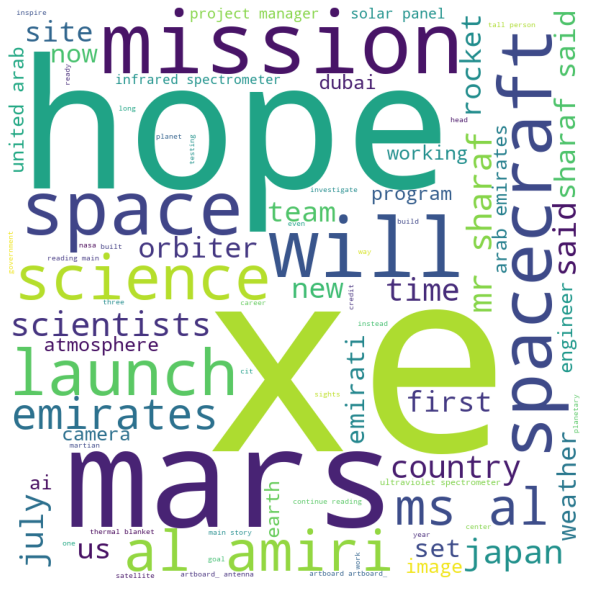

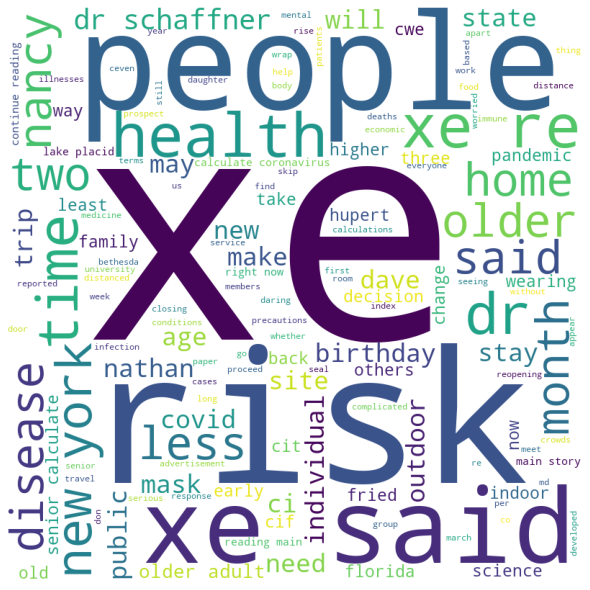

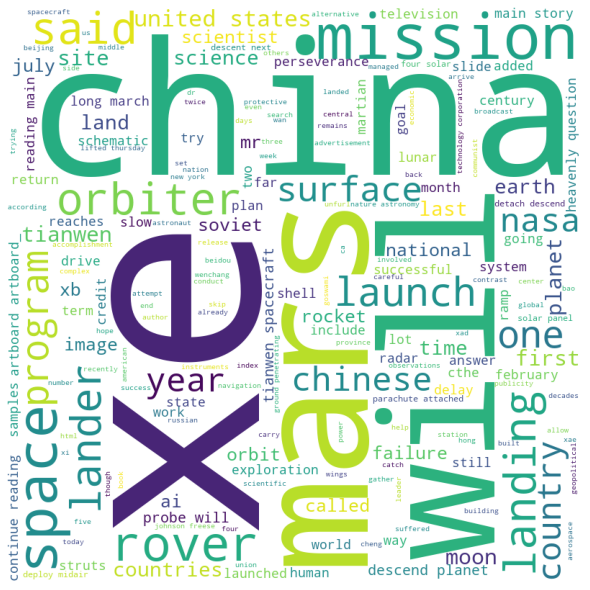

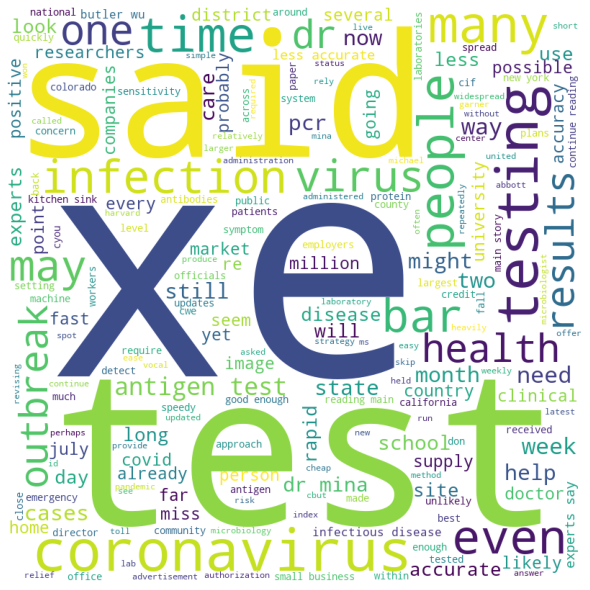

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

generate_word_cloud(data_words[0])
generate_word_cloud(data_words[1])
generate_word_cloud(data_words[2])
generate_word_cloud(data_words[3])

## Above wordcloulds represent data without any filters i.e lemmatization, stop words etc

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

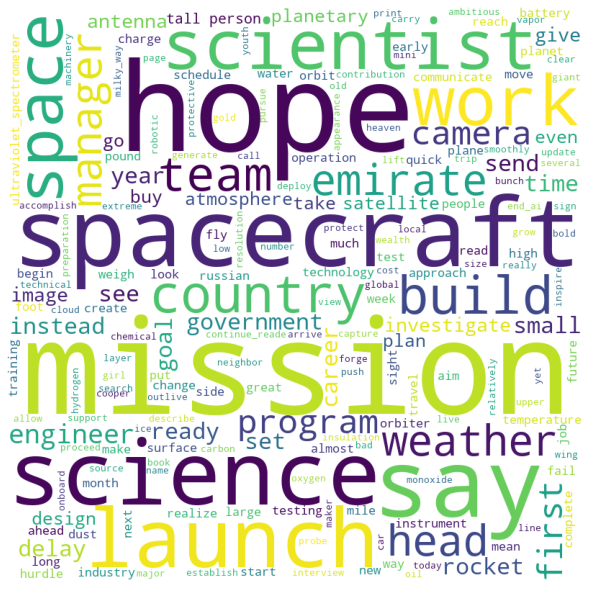

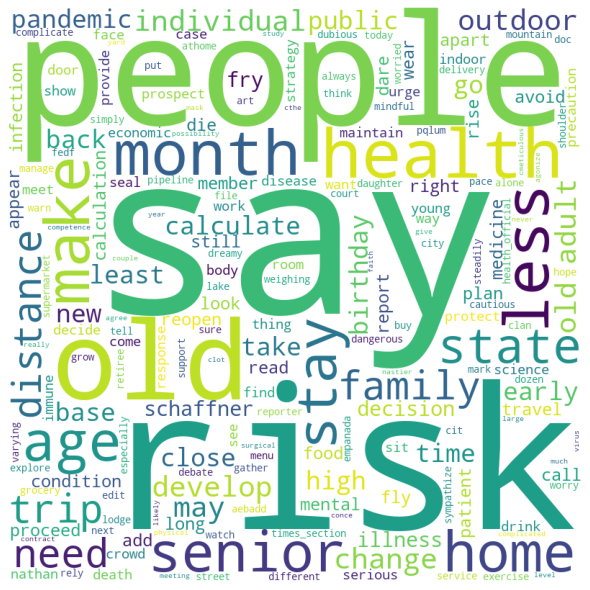

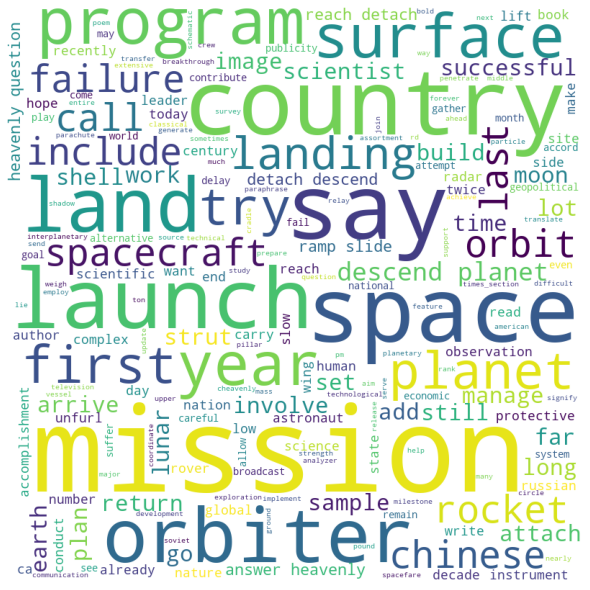

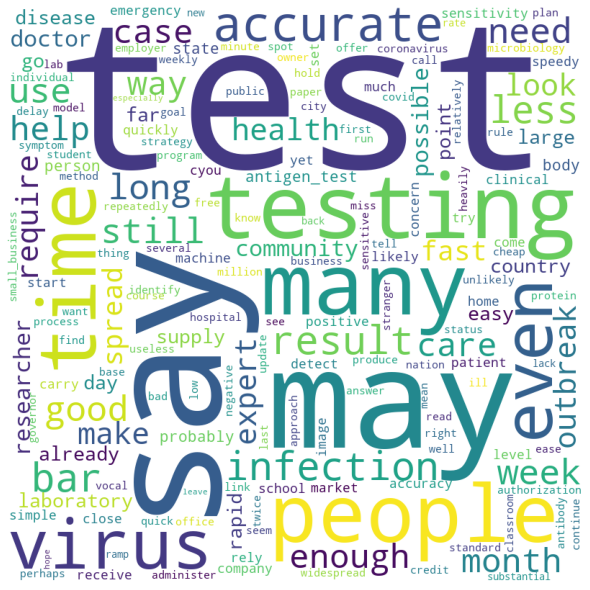

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

generate_word_cloud(data_lemmatized[0])
generate_word_cloud(data_lemmatized[1])
generate_word_cloud(data_lemmatized[2])
generate_word_cloud(data_lemmatized[3])

## Post filtering lemmatization, stop words removal.

In [19]:
import pickle

with open("/content/semi-supervised-lda/data/parsed_content/data_cleansed.txt", "wb") as fp:   #Pickling
  pickle.dump(data_lemmatized, fp)

In [20]:
## check if save to file worked.
with open("/content/semi-supervised-lda/data/parsed_content/data_cleansed.txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)

print(b)

[['science', 'today', 'science', 'set', 'sight', 'mission', 'spacecraft', 'much', 'read', 'support', 'continue_reade', 'emirate', 'set', 'sight', 'delay', 'weather', 'mission', 'goal', 'make', 'contribution', 'government', 'really', 'hope', 'inspire', 'future', 'scientist', 'head', 'science', 'operation', 'manager', 'mission', 'update', 'girl', 'grow', 'look', 'book', 'neighbor', 'milky_way', 'describe', 'say', 'interview', 'realize', 'print', 'page', 'large', 'ever', 'see', 'planet', 'live', 'major', 'science', 'instead', 'aim', 'youth', 'science', 'technology', 'career', 'forge', 'career', 'pursue', 'heaven', 'year', 'old', 'head', 'science', 'operation', 'manager', 'space', 'probe', 'send', 'rocket', 'lift', 'spacecraft', 'call', 'hope', 'begin', 'bold', 'move', 'yet', 'country', 'look', 'establish', 'future', 'long', 'outlive', 'oil', 'wealth', 'see', 'space', 'program', 'way', 'accomplish', 'goal', 'much', 'news', 'next', 'month', 'month', 'line', 'allow', 'robotic', 'spacecraft',

In [22]:
!zip -r /content/semi-supervised-lda.zip /content/semi-supervised-lda

  adding: content/semi-supervised-lda/ (stored 0%)
  adding: content/semi-supervised-lda/.DS_Store (deflated 86%)
  adding: content/semi-supervised-lda/data/ (stored 0%)
  adding: content/semi-supervised-lda/data/parsed_content/ (stored 0%)
  adding: content/semi-supervised-lda/data/parsed_content/data_cleansed.txt (deflated 66%)
  adding: content/semi-supervised-lda/data/.DS_Store (deflated 86%)
  adding: content/semi-supervised-lda/data/raw_content/ (stored 0%)
  adding: content/semi-supervised-lda/data/raw_content/mars-united-arab-emirates.html.txt.gz (stored 0%)
  adding: content/semi-supervised-lda/data/raw_content/seniors-coronavirus-reopenings.html.txt.gz (stored 0%)
  adding: content/semi-supervised-lda/data/raw_content/china-mars-mission.html.txt.gz (stored 0%)
  adding: content/semi-supervised-lda/data/raw_content/rapid-Covid-tests.html.txt.gz (stored 0%)
  adding: content/semi-supervised-lda/data/raw_content/coronavirus-asymptomatic-transmission.html.txt.gz (stored 0%)
  add